In [1]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [2]:
import nfl_data_py as nfl
import pandas as pd
import os
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import matplotlib.image as mpimg
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from scipy.stats import uniform, randint
from skopt.space import Real, Integer
from skopt import BayesSearchCV
import seaborn as sns

import joblib
import sys
import shap as shap

In [3]:
#get shaped dataframe

train_df = pd.read_parquet("../data/train_df.parquet")

In [4]:
features = [
    'air_yards', 'air_epa', 'yac_epa', 'yards_gained',
    'tot_rush_epa', 'tot_pass_epa',
    'Def Rush EPA', 'Def Pass EPA', 'pass_epa', 'rush_epa', 'o_ints', 'o_forced_fumble',
    'o_tac_for_loss', 'o_sacks', 'qb_hit', 'is_home'
]
target = 'Score'

In [5]:

X = train_df[features]
y = train_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)



print(X) 

      air_yards   air_epa   yac_epa  yards_gained  tot_rush_epa  tot_pass_epa  \
0         288.0  0.409077 -0.563374      2.406593     -0.466295      5.530431   
1         285.0  0.534663 -0.879461      3.312500      3.448772    -18.808174   
2         223.0  0.272619 -0.168092      3.113924     -8.325734    -17.605350   
3         254.0  0.880318 -0.450067      4.625000      7.088470     14.367256   
4         153.0 -0.118145  0.513762      5.250000     -7.139055     13.664722   
...         ...       ...       ...           ...           ...           ...   
5241      370.0  0.570054 -0.529343      3.560976     -3.531472    -11.079356   
5242      106.0 -0.152756 -0.146393      3.500000     12.487288    -16.192055   
5243      215.0  0.323960  0.205319      4.732394      3.371261      7.761229   
5244      335.0  0.515233 -0.329818      4.688172    -10.304694     -4.701149   
5245      308.0  0.574284 -0.269123      3.684932      6.516163      1.468198   

      Def Rush EPA  Def Pas

In [6]:
print(y) 

0       19.0
1        9.0
2       13.0
3       31.0
4       33.0
        ... 
5241    19.0
5242    13.0
5243    30.0
5244    24.0
5245    23.0
Name: Score, Length: 5246, dtype: float32


In [7]:
'''
prep data for 70/15/15 split train/validate/test
'''

#85% train+val, 15% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

#split train_val into train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.176, random_state=42
)


In [8]:
#Recombining train and validation sets after tweaking params
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

#Create DMatrix objects 
dtrain = xgb.DMatrix(X_trainval, label=y_trainval)

best_num_boost_rounds = 1049

params = {
    "objective": "reg:squarederror", #base 1
    "eval_metric": "rmse", #base2
    "seed": 42, #base3
    'colsample_bytree': 0.7275902521175045,
    'gamma': 4.2243765548472725,
    'learning_rate': 0.007,
    'max_depth': 4,
    'min_child_weight': 3,
    'n_estimators': 1500,
    'reg_alpha': 0.4960374542934062,
    'reg_lambda': 0.6928903586919394,
    'subsample': 0.739334641781279,
    'objective': 'reg:squarederror',     
    'random_state': 42
}

#Train final model 
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=best_num_boost_rounds
)




/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:33:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [9]:
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    early_stopping_rounds=10,
    nfold=5,
    metrics='rmse',
    seed=42,
    verbose_eval=10
)

print("Best CV Test RMSE:", cv_results['test-rmse-mean'].min())
best_round = cv_results['test-rmse-mean'].idxmin()
print("Best number of boosting rounds:", best_round)

[0]	train-rmse:9.93087+0.03445	test-rmse:9.93607+0.13787
[10]	train-rmse:9.54231+0.03058	test-rmse:9.56144+0.12678
[20]	train-rmse:9.19611+0.02636	test-rmse:9.22969+0.11757
[30]	train-rmse:8.89196+0.02234	test-rmse:8.93987+0.11035
[40]	train-rmse:8.59040+0.01943	test-rmse:8.65177+0.10227
[50]	train-rmse:8.31466+0.01774	test-rmse:8.38952+0.09400
[60]	train-rmse:8.06759+0.01596	test-rmse:8.15517+0.08657
[70]	train-rmse:7.83864+0.01427	test-rmse:7.93934+0.07967
[80]	train-rmse:7.62849+0.01323	test-rmse:7.74248+0.07337
[90]	train-rmse:7.43888+0.01339	test-rmse:7.56544+0.07023
[100]	train-rmse:7.27207+0.01276	test-rmse:7.40986+0.06853
[110]	train-rmse:7.11349+0.01348	test-rmse:7.26213+0.06599
[120]	train-rmse:6.97024+0.01392	test-rmse:7.13133+0.06509
[130]	train-rmse:6.83916+0.01482	test-rmse:7.00992+0.06466
[140]	train-rmse:6.71929+0.01572	test-rmse:6.90154+0.06494
[150]	train-rmse:6.61353+0.01626	test-rmse:6.80781+0.06668
[160]	train-rmse:6.51820+0.01729	test-rmse:6.72336+0.06742
[170]	tr

In [10]:
'''
evaluate against test set
'''

dtest = xgb.DMatrix(X_test)

y_pred = model.predict(dtest)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")

'''
using above parameters, RMSE = 5.78 and MAE = 4.53
'''

Test RMSE: 5.53
Test MAE: 4.32


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


'\nusing above parameters, RMSE = 5.78 and MAE = 4.53\n'

In [11]:
sample_preds = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred
})
print(sample_preds.head(100))

    Actual  Predicted
0     20.0  26.495583
1     24.0  25.316286
2     37.0  33.619545
3     20.0  21.838894
4     16.0  17.218822
..     ...        ...
95    22.0  19.401272
96    10.0  11.388863
97    28.0  30.576845
98    27.0  23.774279
99    27.0  27.414387

[100 rows x 2 columns]


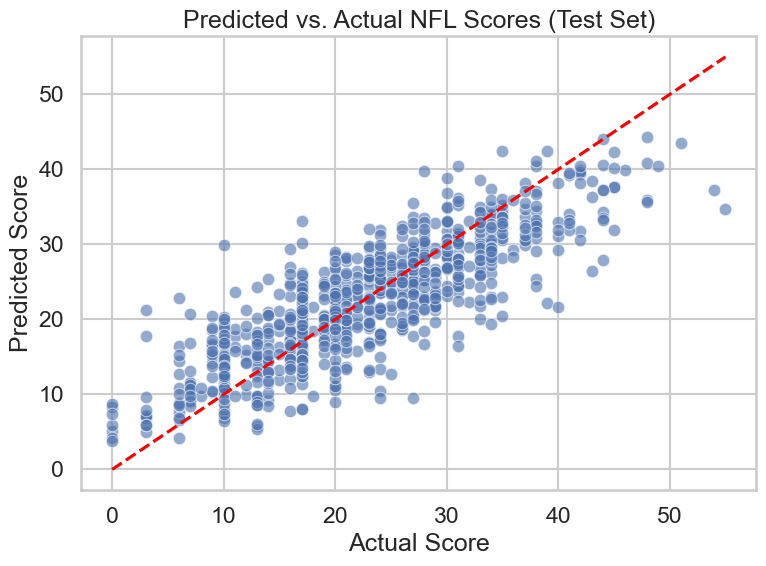

In [12]:



results_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred
})


sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x="Actual", y="Predicted", alpha=0.6)


max_val = max(results_df["Actual"].max(), results_df["Predicted"].max())
min_val = min(results_df["Actual"].min(), results_df["Predicted"].min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')


plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Predicted vs. Actual NFL Scores (Test Set)")
plt.tight_layout()
plt.show()

In [13]:
'''
**Saving model I intend to use for inferencing:

'''

os.makedirs("../models", exist_ok=True)

model.save_model("../models/xgb_final_model.json")


In [14]:
'''the next section reviews the model for correlation between inputs and target.
Nothing jumped out in this review as being egregiously bad, so for the time bring this v1 of the model remains.

'''

'the next section reviews the model for correlation between inputs and target.\nNothing jumped out in this review as being egregiously bad, so for the time bring this v1 of the model remains.\n\n'

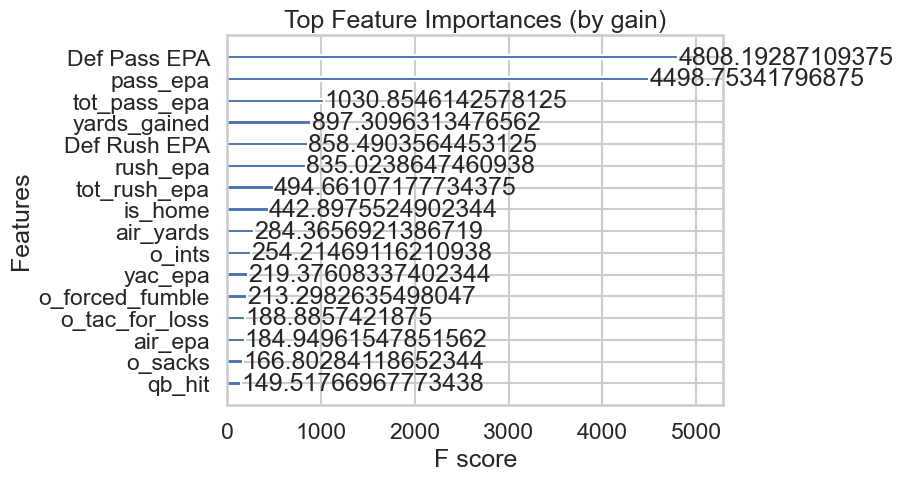

In [15]:
xgb.plot_importance(model, importance_type='gain', max_num_features=30)
plt.title("Top Feature Importances (by gain)")
plt.show()

In [16]:
#importance scores
importance = model.get_score(importance_type='gain')  
sorted_importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))

for feature, score in sorted_importance.items():
    print(f"{feature}: {score:.4f}")


Def Pass EPA: 4808.1929
pass_epa: 4498.7534
tot_pass_epa: 1030.8546
yards_gained: 897.3096
Def Rush EPA: 858.4904
rush_epa: 835.0239
tot_rush_epa: 494.6611
is_home: 442.8976
air_yards: 284.3657
o_ints: 254.2147
yac_epa: 219.3761
o_forced_fumble: 213.2983
o_tac_for_loss: 188.8857
air_epa: 184.9496
o_sacks: 166.8028
qb_hit: 149.5177


In [17]:
#running an ablation test to see if removing low-correlated features helps


#remove 'qb_hit' and 'o_sacks' 
ablated_features = [f for f in features if f not in ['qb_hit', 'o_sacks']]

# Create DMatrix using reduced features
dtrain_ablated = xgb.DMatrix(X_trainval[ablated_features], label=y_trainval)
dtest_ablated = xgb.DMatrix(X_test[ablated_features], label=y_test)

# Train model on ablated features
model_ablated = xgb.train(params=params, dtrain=dtrain_ablated, num_boost_round=best_num_boost_rounds)

# Evaluate performance (e.g., RMSE on test set)
y_pred_ablated = model_ablated.predict(dtest_ablated)
rmse_ablated = mean_squared_error(y_test, y_pred_ablated, squared=False)
mae_ablated = mean_absolute_error(y_test, y_pred_ablated)
print(f"Ablated Model RMSE: {rmse_ablated:.4f}")
print(f"Ablated Model MAE: {mae_ablated:.4f}")




/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:34:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Ablated Model RMSE: 5.5216
Ablated Model MAE: 4.3136


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [18]:
# Define your original features and target
features = [
    'air_yards', 'air_epa', 'yac_epa', 'yards_gained',
    'tot_rush_epa', 'tot_pass_epa',
    'Def Rush EPA', 'Def Pass EPA', 'pass_epa', 'rush_epa',
    'o_ints', 'o_forced_fumble', 'o_tac_for_loss', 'o_sacks',
    'qb_hit', 'is_home'
]
target = 'Score'

X = train_df[features]
y = train_df[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train full model for baseline
dtrain_full = xgb.DMatrix(X_train, label=y_train)
dtest_full = xgb.DMatrix(X_test, label=y_test)

model_full = xgb.train(params=params, dtrain=dtrain_full, num_boost_round=best_num_boost_rounds)
y_pred_full = model_full.predict(dtest_full)

rmse_full = mean_squared_error(y_test, y_pred_full, squared=False)
mae_full = mean_absolute_error(y_test, y_pred_full)

print(f"BASELINE Model — RMSE: {rmse_full:.4f}, MAE: {mae_full:.4f}")

# Loop over features and test ablation
results = []

for feature_to_remove in features:
    ablated_features = [f for f in features if f != feature_to_remove]
    
    dtrain_ablated = xgb.DMatrix(X_train[ablated_features], label=y_train)
    dtest_ablated = xgb.DMatrix(X_test[ablated_features], label=y_test)

    model_ablated = xgb.train(params=params, dtrain=dtrain_ablated, num_boost_round=best_num_boost_rounds)
    y_pred_ablated = model_ablated.predict(dtest_ablated)

    rmse = mean_squared_error(y_test, y_pred_ablated, squared=False)
    mae = mean_absolute_error(y_test, y_pred_ablated)

    results.append({
        'feature_removed': feature_to_remove,
        'rmse': rmse,
        'mae': mae,
        'delta_rmse': rmse - rmse_full,
        'delta_mae': mae - mae_full
    })

ablation_df = pd.DataFrame(results).sort_values(by='delta_rmse', ascending=False)

print("\nAblation Results:")
print(ablation_df.to_string(index=False))

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:34:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:34:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


BASELINE Model — RMSE: 5.6266, MAE: 4.4211


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:34:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:34:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/o


Ablation Results:
feature_removed     rmse      mae  delta_rmse  delta_mae
   tot_pass_epa 5.945522 4.684486    0.318957   0.263348
   tot_rush_epa 5.706166 4.492468    0.079601   0.071330
        is_home 5.685119 4.474831    0.058554   0.053693
      air_yards 5.675222 4.463956    0.048657   0.042818
         o_ints 5.673758 4.459244    0.047193   0.038106
o_forced_fumble 5.644298 4.424588    0.017733   0.003450
   Def Pass EPA 5.637506 4.428408    0.010941   0.007269
       pass_epa 5.637506 4.428408    0.010941   0.007269
        yac_epa 5.637091 4.429374    0.010526   0.008235
 o_tac_for_loss 5.636776 4.427689    0.010211   0.006550
        o_sacks 5.630559 4.421673    0.003994   0.000535
        air_epa 5.630455 4.430074    0.003890   0.008936
   Def Rush EPA 5.630093 4.421933    0.003528   0.000794
         qb_hit 5.629237 4.424884    0.002672   0.003746
       rush_epa 5.626330 4.422339   -0.000235   0.001201
   yards_gained 5.614064 4.405854   -0.012501  -0.015284


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


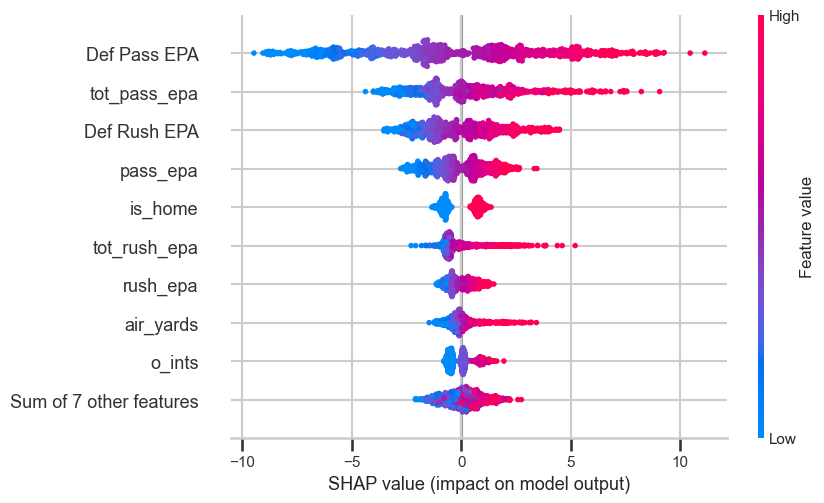

In [19]:
import shap
explainer = shap.Explainer(model_full)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

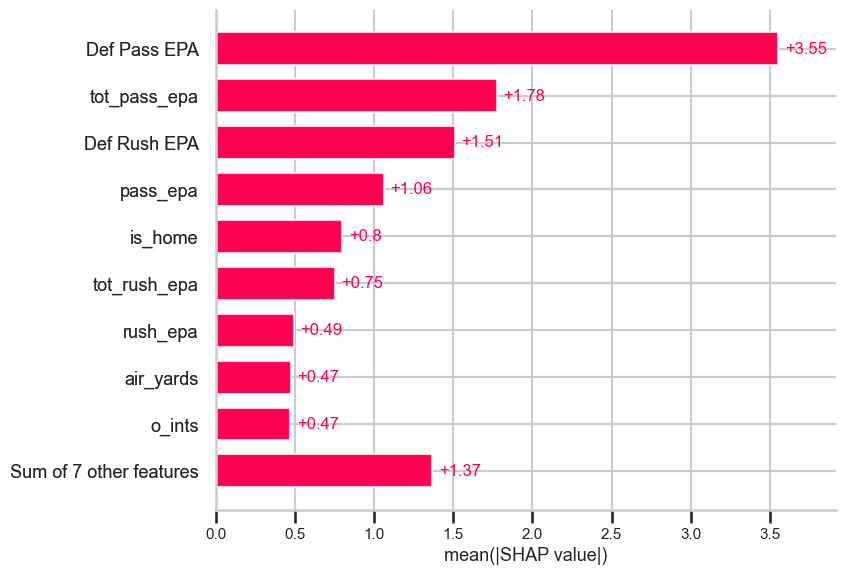

In [20]:
shap.plots.bar(shap_values)

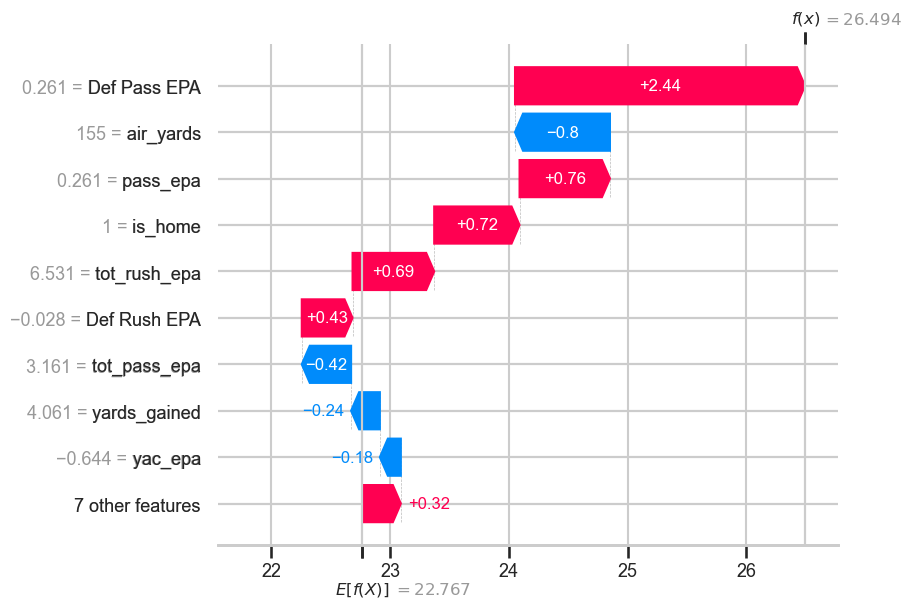

In [21]:
shap.plots.waterfall(shap_values[0])